#Import

In [ ]:
!pip install jmetalpy

     |████████████████████████████████| 110 kB 4.2 MB/s 
  Created wheel for jmetalpy: filename=jmetalpy-1.5.5-py3-none-any.whl size=196212 sha256=93dbf5322b9383f97fefc56f32569241aa5a95b4670f8968f635bf339bb84ee6
  Stored in directory: /root/.cache/pip/wheels/ca/8a/fd/c7b0b43039ee307e366569834484b5aa51ff81d609288dfcd2
Successfully built jmetalpy


In [ ]:
import math
import random
import re
import json
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import threading
from threading import Thread

import jmetal


# single objective problem
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm

#operator
from jmetal.operator.mutation import PermutationSwapMutation,PolynomialMutation
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator import BinaryTournamentSelection, BestSolutionSelection

# util
from jmetal.util.comparator import MultiComparator
from jmetal.util.ranking import StrengthRanking
from jmetal.util.density_estimator import KNearestNeighborDensityEstimator
from jmetal.util import termination_criterion
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.termination_criterion import StoppingByEvaluations

#core
from jmetal.core.quality_indicator import *
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution, Solution

#lab
from jmetal.lab.experiment import Experiment, Job, generate_summary_from_experiment



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Read Files

In [28]:
def read_tsplib_file(filename):
    if filename is None:
        raise FileNotFoundError('Filename can not be None')
    with open(filename) as file:
        lines = file.readlines()
        data = [line.lstrip() for line in lines if line != ""]
        dimension = re.compile(r'[^\d]+')
        for item in data:
            if item.startswith('DIMENSION'):
                dimension = int(dimension.sub('', item))
                break
        c = [-1.0] * (2 * dimension)
        cities_coord = []
        for item in data:
            if item[0].isdigit():
                j, coordX, coordY = [float(x.strip()) for x in item.split(' ')]
                c[2 * (int(j) - 1)] = coordX
                c[2 * (int(j) - 1) + 1] = coordY
                cities_coord.append([coordX,coordY])
        cities = pd.DataFrame(cities_coord)
        matrix = [[-1] * dimension for _ in range(dimension)]
        for k in range(dimension):
            matrix[k][k] = 0
            for j in range(k + 1, dimension):
                dist = math.sqrt((c[k * 2] - c[j * 2]) ** 2 + (c[k * 2 + 1] - c[j * 2 + 1]) ** 2)
                dist = round(dist)
                matrix[k][j] = dist
                matrix[j][k] = dist
        return matrix, dimension, cities

#TSP

In [29]:
class myTSP(PermutationProblem):
    def __init__(self, distance_matrix, number_of_cities, fitness_log):
        super(myTSP, self).__init__()
        self.distance_matrix = distance_matrix
        self.number_of_variables = number_of_cities
        self.obj_directions = [self.MINIMIZE]
        self.number_of_objectives = 1
        self.number_of_constraints = 0
        self.fitness_log = fitness_log
        
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        fitness = 0
        for i in range(self.number_of_variables - 1):
            x = solution.variables[i]
            y = solution.variables[i + 1]
            fitness += self.distance_matrix[x][y]
        first_city, last_city = solution.variables[0], solution.variables[-1]
        fitness += self.distance_matrix[first_city][last_city]
        solution.objectives[0] = fitness
        self.fitness_log.append(fitness)
        return solution
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,
                                           number_of_objectives=self.number_of_objectives)
        new_solution.variables = random.sample(range(self.number_of_variables), k=self.number_of_variables)
        return new_solution

    @property
    def number_of_cities(self):
        return self.number_of_variables

    def get_name(self):
        return 'Symmetric TSP'

#Problem

In [30]:
class problem():
  def __init__(self):
        self.problem_name = 'Djibouti 38 TSP'
        self.optimal_fitness = 6656
        self.location = "/dj38.tsp"
        self.dist_matrix, self.nb_cities, self.cities_coord = read_tsplib_file(self.location)

  def myProblem(self, fitness_log): 
    return myTSP(self.dist_matrix, self.nb_cities, fitness_log)

  def getProblemName(self):
    return self.problem_name

  def getOptimalFitness(self):
    return self.optimal_fitness
  
  def getCityCoord(self):
    return self.cities_coord

#Save To File

In [31]:
def calltosave(d, i):
  try:
    x = problem()
    filename = "output"
    filename2 = x.getProblemName()
    path = os.path.join(filename, filename2)
    Path(path).mkdir(parents=True, exist_ok=True)     
  except:
    pass

  with open("%s/%s_TSP.txt" %(path, i), 'w', encoding='utf-8') as f:
    f.write(""+i+"°iteration output:\n")
    json.dump(d, f, indent=4, separators=(',',': '))
    
    f.write("\ngraph iteration output:\n")
    f.write("--"*60)
    f.write("\n")
  f.close()

In [32]:
def create_output_file(my_algo, pop_evolved, log, params, i):
    algorithm_name = my_algo.get_name()
    solution_x = pop_evolved.variables
    fitness = pop_evolved.objectives[0]
    n_evals = my_algo.evaluations
    duration = my_algo.total_computing_time
    lensolution = solution_x 
    x = problem()

    d = {}
    d['Function'] = x.getProblemName()
    d['Problem dimension'] = lensolution
    d['Global Optimum'] = x.getOptimalFitness()
    d['Algorithm'] = algorithm_name
    d['Parameters'] = params
    d['Fitness'] = fitness
    d['Solution'] = solution_x
    d['Nb of functions evaluations'] = n_evals
    d['Computational time in seconds'] = duration
    d['Stopping criterion in evaluations'] = maxevals

    calltosave(d, i)

#Output

In [33]:
#Last Element Output
class lastOutput():
  def __init__(self, fitness_log, result):
        self.fitness_log = fitness_log
        self.result = result

  # print graph
  def plotMap(self):
    plt.plot(self.fitness_log[::1000])
    plt.xlabel("evaluations (x1000)")
    plt.ylabel("fitness")
    plt.show()

  # print map
  def printMap(self):
    cities_coord = problem().getCityCoord()
    xlist = [cities_coord.iloc[i,0] for i in self.result.variables]
    ylist = [cities_coord.iloc[i,1] for i in self.result.variables]

    xlist.append(xlist[0])
    ylist.append(ylist[0])

    plt.figure(figsize=(16,8))
    for idx,city in enumerate(cities_coord.values):
      plt.scatter(city[0],city[1])
      plt.text(city[0]-20, city[1]+40, str(idx), fontsize=10)

    plt.plot(xlist, ylist, linestyle='-')
    plt.plot(xlist, ylist, linestyle='-')
    plt.axis('scaled')
    plt.show()

  #run all functions
  def getResults(self):
        if __name__ == '__main__':
            self.plotMap()
            self.printMap()
            #Thread(target = self.plotMap).start()
            #Thread(target = self.printMap).start()

#Problem Execution

In [34]:
class Main():
  def __init__(self, run, maxevals, popsize, offspring, mut_prob, cross_prob):
        self.run = run
        self.maxevals = maxevals
        self.popsize = popsize
        self.offspring = offspring
        self.mut_prob = mut_prob
        self.cross_prob = cross_prob
        self.i = 0
        self.fitness_log = []

  def start(self):
    for i in range(run):
      print(f"\n{i+1}° runs:")
      self.execute()
    self.output()

  def execute(self):
    select = BinaryTournamentSelection(
	  		  		MultiComparator([StrengthRanking.get_comparator(),
		  		  					 KNearestNeighborDensityEstimator.get_comparator()]
			  	  				   ))

    termin = termination_criterion.StoppingByEvaluations(max_evaluations=maxevals)

    algorithm = GeneticAlgorithm(
      problem=problem().myProblem(self.fitness_log),
      population_size=popsize,
      offspring_population_size=offspring,
      mutation=PermutationSwapMutation(mut_prob), 
      crossover=PMXCrossover(cross_prob),
      selection=select,
      termination_criterion=termin,
    )

    params = {
              'population':popsize, 
  	          'offspring':offspring, 
	            'mutation probability': mut_prob, 
		          'crossover probability': cross_prob,
  		  }

    # Call GeneticAlgorithm and execute it #
    algorithm.observable.register(ProgressBarObserver(max=maxevals))
    algorithm.run()

    self.result = algorithm.get_result()
    create_output_file(algorithm, self.result, self.fitness_log, params, str(self.i+1))

  def output(self):    
    call = lastOutput(self.fitness_log, self.result)#.getResults()
    call.plotMap()
    call.printMap()
    


#RUN


1° runs:


Progress: 200200it [00:38, 5229.97it/s]                            



2° runs:


Progress: 200200it [00:32, 6252.50it/s]



3° runs:


Progress: 200200it [00:32, 6209.55it/s]



4° runs:


Progress: 200200it [00:31, 6377.03it/s]



5° runs:


Progress: 200200it [00:31, 6328.11it/s]


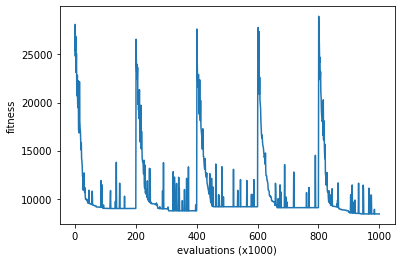

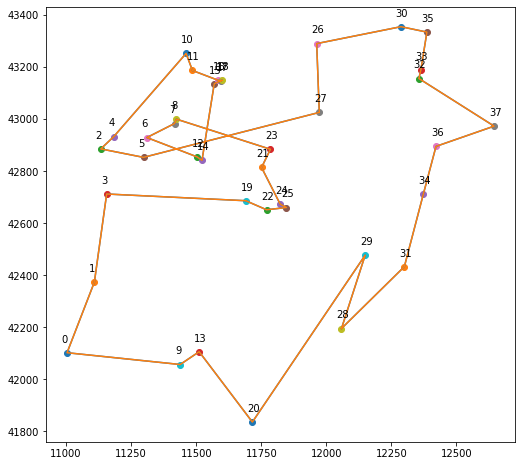

In [35]:
if __name__ == '__main__':
  #params
  run = 5
  maxevals = 200000
  popsize = 440
  offspring = 440
  mut_prob = 0.08
  cross_prob = 0.77

  #call function
  execute = Main(run, maxevals, popsize, offspring, mut_prob, cross_prob).start()


#IGD indicador de qualidade
#friedman, wilcoxon stat test